## Package and helper imports

In [75]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from textblob import TextBlob

from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, LabelEncoder

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import optuna

import re
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as st
from scipy import sparse
from scipy.sparse import hstack, csr_matrix
import pyarrow
import pickle

In [2]:
# Downloads and display options
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
punctuation = string.punctuation
stop_words = set(stopwords.words('english'))
pd.options.display.max_columns = None
pd.options.display.max_rows = None
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\schel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\schel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\schel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\schel\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Define functions

In [3]:
def clean_text_df(data):
    for i in [char for char in ':;"?,/|\\}{1234567890.~!@#$%^&*_+=<>']:
        data.unvec=data.unvec.apply(lambda x: str(x).replace(i,""))

    data.unvec=data.unvec.apply(lambda x: str(x).replace("-"," "))
    data.unvec=data.unvec.apply(lambda x: str(x).replace("X",""))
    data.unvec=data.unvec.apply(lambda x: str(x).replace("XX",""))
    data.unvec=data.unvec.apply(lambda x: str(x).replace("XXX",""))
    data.unvec=data.unvec.apply(lambda x: str(x).replace("XXXX",""))
    data.unvec=data.unvec.apply(lambda x: str(x).replace("XXXXX",""))
    data.unvec=data.unvec.apply(lambda x: str(x).replace("XXXXXX",""))
    data.unvec=data.unvec.apply(lambda x: str(x).replace("XXXXXXX",""))
    data.unvec=data.unvec.apply(lambda x: str(x).replace("XXXXXXXX","")) # removes redactions 

    stopword_dict= set(stopwords.words('english'))

    def sw_remover(arr):
        res=[]
        for i in arr:
            if i not in stopword_dict:
                res.append(i)
        return res

    # def digit_remover(arr):
    #     res=[]
    #     for i in arr:
    #         if i.isdigit()==False:
    #             res.append(i)
    #     return res

    def lemmatizer(arr):
        lem=nltk.stem.WordNetLemmatizer()
        res=[lem.lemmatize(i) for i in arr]
        return res

    def joiner(arr):
        if len(arr)==0:
            return ''
        elif len(arr)==1:
            return arr[0]
        else:
            return ' '.join(arr)
    
    data.unvec=data.unvec.apply(lambda x: re.sub(r'\[rnt]',"",x))
    data.unvec=data.unvec.apply(lambda x: x.lower())
    data.unvec=data.unvec.apply(lambda x: x.split())
    data.unvec=data.unvec.apply(sw_remover)
    data.unvec=data.unvec.apply(lemmatizer)
    data.unvec=data.unvec.apply(joiner)

    data['len']=data['unvec'].apply(len)
    
    return data

In [ ]:
# def cleanText(text):
#     text = BeautifulSoup(text, "lxml").text
#     text = re.sub(r'\[rnt]', '', text) 
#     text = re.sub(r'http\S+', r'<URL>', text)
#     text = text.lower()
#     text = text.replace('x', '')
#     return text

In [4]:
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

In [5]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words)) for doc in sents]) #(doc.words, steps=20))
    return targets, regressors

## Import FEATURE-ENGINEERED training and validation data from EDA

In [6]:
df_train = pd.read_parquet('./input/dataframes/df_train_FE.parquet')
df_train.head()

,consumer_complaint_narrative,timely_response,consumer_disputed?,days_between_receipt_and_sent,sub_product_freq,sub_product_null_flag,sub_product_low_flag,issue_freq,issue_low_flag,sub_issue_freq,sub_issue_null_flag,sub_issue_low_flag,company_public_response_freq,company_public_response_null_flag,company_public_response_low_flag,company_freq,company_low_flag,state_freq,state_null_flag,state_low_flag,zipcode_freq,zipcode_null_flag,zipcode_low_flag,"Not Older American, Not Servicemember",Older American,"Older American, Servicemember",Servicemember,Closed,Closed with explanation,Closed with monetary relief,Closed with non-monetary relief,Untimely response
0,"Dear Sir or Madam, Ever since XXXX XXXX XXXX s...",1,0,0,0.098495,0,0,0.097832,0,-1.000000,1,0,-1.000000,1,0,0.020208,0,0.018711,0,0,0.001198,0,0,1,0,0,0,0,1,0,0,0
1,"on XXXX XXXX, 2015 there was an ACH transactio...",1,0,0,0.019973,0,0,0.020742,0,-1.000000,1,0,-1.000000,1,0,0.003037,1,0.089449,0,0,0.009858,0,0,1,0,0,0,0,1,0,0,0
2,My wife has not received a paper bill from Cha...,1,0,0,-1.000000,1,0,0.018283,0,-1.000000,1,0,-1.000000,1,0,0.038897,0,0.017599,0,0,0.002438,0,0,1,0,0,0,0,1,0,0,0
3,the company m & M funding has been harassing f...,1,0,6,0.005902,0,1,0.020015,0,0.002545,0,1,-1.000000,1,0,0.000021,1,0.016786,0,0,0.001711,0,0,1,0,0,0,0,1,0,0,0
4,Can my reverse mortgage lender refuse to conti...,1,0,1,0.017449,0,0,0.024741,0,-1.000000,1,0,0.055727,0,0,0.045890,0,0.003143,0,1,0.000128,0,1,0,0,0,1,0,1,0,0,0


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46764 entries, 0 to 46763
Data columns (total 32 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   consumer_complaint_narrative           46764 non-null  object 
 1   timely_response                        46764 non-null  int32  
 2   consumer_disputed?                     46764 non-null  int32  
 3   days_between_receipt_and_sent          46764 non-null  int64  
 4   sub_product_freq                       46764 non-null  float64
 5   sub_product_null_flag                  46764 non-null  int32  
 6   sub_product_low_flag                   46764 non-null  int32  
 7   issue_freq                             46764 non-null  float64
 8   issue_low_flag                         46764 non-null  int32  
 9   sub_issue_freq                         46764 non-null  float64
 10  sub_issue_null_flag                    46764 non-null  int32  
 11  su

In [8]:
df_train.shape

(46764, 32)

In [9]:
list(df_train.columns)

['consumer_complaint_narrative',
 'timely_response',
 'consumer_disputed?',
 'days_between_receipt_and_sent',
 'sub_product_freq',
 'sub_product_null_flag',
 'sub_product_low_flag',
 'issue_freq',
 'issue_low_flag',
 'sub_issue_freq',
 'sub_issue_null_flag',
 'sub_issue_low_flag',
 'company_public_response_freq',
 'company_public_response_null_flag',
 'company_public_response_low_flag',
 'company_freq',
 'company_low_flag',
 'state_freq',
 'state_null_flag',
 'state_low_flag',
 'zipcode_freq',
 'zipcode_null_flag',
 'zipcode_low_flag',
 'Not Older American, Not Servicemember',
 'Older American',
 'Older American, Servicemember',
 'Servicemember',
 'Closed',
 'Closed with explanation',
 'Closed with monetary relief',
 'Closed with non-monetary relief',
 'Untimely response']

In [10]:
df_val = pd.read_parquet('./input/dataframes/df_val_FE.parquet')
df_val.head()

,consumer_complaint_narrative,timely_response,consumer_disputed?,days_between_receipt_and_sent,sub_product_freq,sub_product_null_flag,sub_product_low_flag,issue_freq,issue_low_flag,sub_issue_freq,sub_issue_null_flag,sub_issue_low_flag,company_public_response_freq,company_public_response_null_flag,company_public_response_low_flag,company_freq,company_low_flag,state_freq,state_null_flag,state_low_flag,zipcode_freq,zipcode_null_flag,zipcode_low_flag,"Not Older American, Not Servicemember",Older American,"Older American, Servicemember",Servicemember,Closed,Closed with explanation,Closed with monetary relief,Closed with non-monetary relief,Untimely response
0,I bought a house in XXXX XXXX in XXXX. It was ...,1,0,0,0.040416,0,0,0.076057,0,-1.000000,1,0,0.291824,0,0,0.051108,0,0.149975,0,0,0.001996,0,0,1,0,0,0,0,1,0,0,0
1,XX/XX/XXXX my husband and I took an equity lin...,1,0,0,0.013044,0,0,0.023950,0,-1.000000,1,0,0.291824,0,0,0.051108,0,0.034571,0,0,0.001212,0,0,1,0,0,0,0,1,0,0,0
2,"Dear sir/madam, I want ESCALLATE to remove the...",1,1,0,0.039490,0,0,0.115546,0,0.070283,0,0,0.291824,0,0,0.000143,1,0.037066,0,0,0.006914,0,0,1,0,0,0,1,0,0,0,0
3,I had XXXX Alliance One Accounts on my credit ...,1,0,0,0.077625,0,0,0.024449,0,0.017963,0,0,-1.000000,1,0,0.000998,1,0.022168,0,0,0.003707,0,0,1,0,0,0,0,1,0,0,0
4,Portfolio Recovery continues to contact me and...,1,0,0,0.052890,0,0,0.039775,0,0.023024,0,0,-1.000000,1,0,0.010692,0,0.031150,0,0,0.000356,0,1,1,0,0,0,0,0,0,1,0


In [11]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14029 entries, 0 to 14028
Data columns (total 32 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   consumer_complaint_narrative           14029 non-null  object 
 1   timely_response                        14029 non-null  int32  
 2   consumer_disputed?                     14029 non-null  int32  
 3   days_between_receipt_and_sent          14029 non-null  int64  
 4   sub_product_freq                       14029 non-null  float64
 5   sub_product_null_flag                  14029 non-null  int32  
 6   sub_product_low_flag                   14029 non-null  int32  
 7   issue_freq                             14029 non-null  float64
 8   issue_low_flag                         14029 non-null  int32  
 9   sub_issue_freq                         14029 non-null  float64
 10  sub_issue_null_flag                    14029 non-null  int32  
 11  su

In [12]:
df_val.shape

(14029, 32)

In [13]:
list(df_val.columns)

['consumer_complaint_narrative',
 'timely_response',
 'consumer_disputed?',
 'days_between_receipt_and_sent',
 'sub_product_freq',
 'sub_product_null_flag',
 'sub_product_low_flag',
 'issue_freq',
 'issue_low_flag',
 'sub_issue_freq',
 'sub_issue_null_flag',
 'sub_issue_low_flag',
 'company_public_response_freq',
 'company_public_response_null_flag',
 'company_public_response_low_flag',
 'company_freq',
 'company_low_flag',
 'state_freq',
 'state_null_flag',
 'state_low_flag',
 'zipcode_freq',
 'zipcode_null_flag',
 'zipcode_low_flag',
 'Not Older American, Not Servicemember',
 'Older American',
 'Older American, Servicemember',
 'Servicemember',
 'Closed',
 'Closed with explanation',
 'Closed with monetary relief',
 'Closed with non-monetary relief',
 'Untimely response']

## Import label-encoded targets for training and validation data

In [14]:
# Training data targets
y_train = pd.read_parquet('./input/y_targets/y_train_LE.parquet')

In [15]:
product_train = y_train['label'].value_counts()
print(product_train)

4     12286
6     10443
3      8768
2      5550
0      3998
1      2575
10     1490
9       603
8       508
5       466
7        77
Name: label, dtype: int64


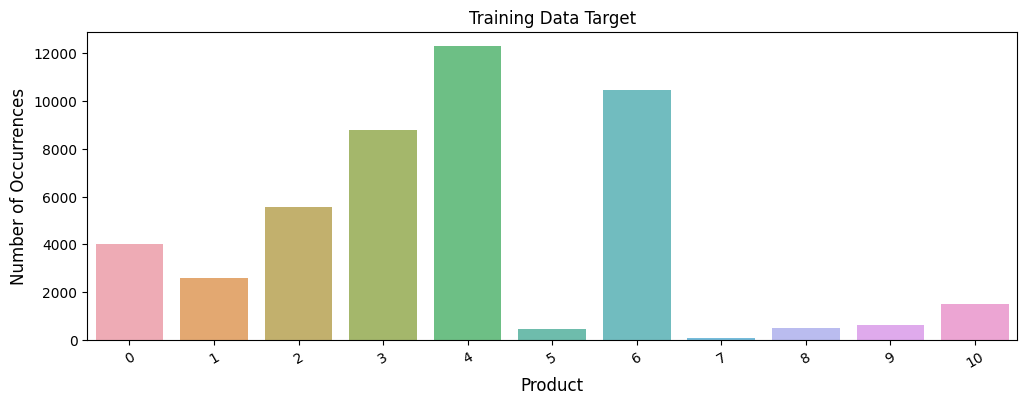

In [16]:
plt.figure(figsize=(12,4))
sns.barplot(x=product_train.index, y=product_train.values, alpha=0.8)
plt.title('Training Data Target')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.xticks(rotation=30)
plt.show()

In [17]:
# Validation data targets
y_val = pd.read_parquet('./input/y_targets/y_val_LE.parquet')

In [18]:
product_val = y_val['label'].value_counts()
print(product_val)

4     3686
6     3133
3     2630
2     1665
0     1199
1      772
10     447
9      181
8      153
5      140
7       23
Name: label, dtype: int64


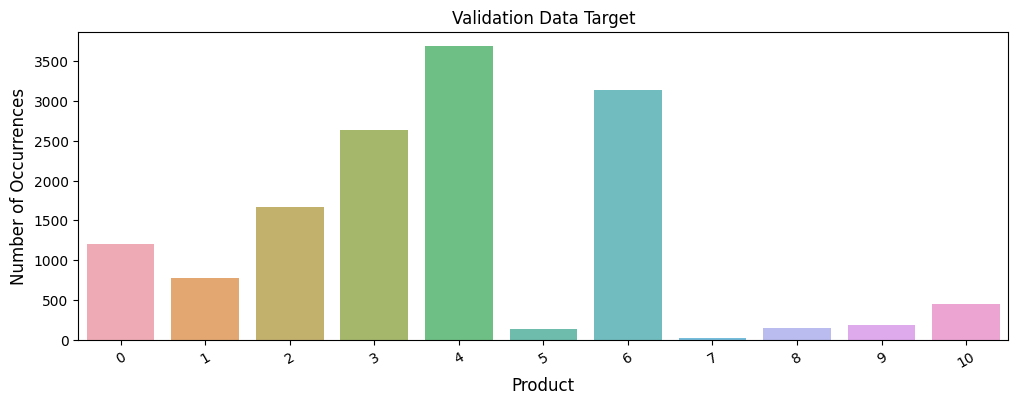

In [19]:
plt.figure(figsize=(12,4))
sns.barplot(x=product_val.index, y=product_val.values, alpha=0.8)
plt.title('Validation Data Target')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.xticks(rotation=30)
plt.show()

## Inspect unvectorized text and ensure all is converted to string for both Training and Validation Data

In [20]:
for i in df_train['consumer_complaint_narrative'].head(5):
    print(i)
    print("#####################")

Dear Sir or Madam, Ever since XXXX XXXX XXXX sold our Mortgage Loan to XXXX, we have had nothing but problems. My husband and I back in 2009, tried to modify the loan. This was an absolute nightmare. After submitting information several times and going through numerous " scheduling '' of calls with Loan counselors, who when I finally got to talk to them, had nothing of substance to discuss or help me with and offered no guidance or help. They would tell me that I needed to get certain pieces of info. and schedule yet another call ( which were always 2 weeks later ) and take it from there, then it was like XXXX XXXX XXXX ... .. I would schedule call after call just to discuss separate pieces of my Loan Mod. Application. It made NO SENSE! I got nowhere and gave up. I have a file 3 inches thick with my application, with forms and notes and all the back up info that I scanned to them, which they claimed to never have received ... .. I finally gave up. With my husband laid off due the const

In [21]:
df_train = df_train.rename({'consumer_complaint_narrative':'unvec'},axis=1)

In [22]:
df_train['unvec'] = df_train['unvec'].astype(str)

In [23]:
for i in df_val['consumer_complaint_narrative'].head(5):
    print(i)
    print("#####################")

I bought a house in XXXX XXXX in XXXX. It was my primary residence. I fixed it up and made the payments regularly until about XXXX XXXX at which point I called the bank to see what options were available. I explained that I was unable to make the payments any longer, that my parents were sick and that I had put the house on the market in XXXX and moved to XXXX. I gave them all the information they requested. Since then they have continually bounced me from one representative to another almost like a shell game. They did this until the information was outdated and I had to submit all new information such as my XXXX tax statements, bank statements, recent pay stubs, and an explanation why I was unable to make the payments. They would then tell me via mail that I do n't meet investor guidelines. I talked to HUD and they tell me I do! The bank assigns me another representative and we go through the whole procedure again. By now we are 9 months into this process doing this hide and seek and

In [24]:
df_val = df_val.rename({'consumer_complaint_narrative':'unvec'},axis=1)

In [25]:
df_val['unvec'] = df_val['unvec'].astype(str)

## Join text and targets for tagging

In [26]:
df_train = df_train.join(y_train)

In [27]:
df_val = df_val.join(y_val)

## Sanitize text

In [28]:
df_train = clean_text_df(df_train)

In [29]:
for i in df_train['unvec'].head(5):
    print(i)
    print("#####################")

dear sir madam ever since sold mortgage loan nothing problem husband back tried modify loan absolute nightmare submitting information several time going numerous scheduling '' call loan counselor finally got talk nothing substance discus help offered guidance help would tell needed get certain piece info schedule yet another call ( always week later ) take like would schedule call call discus separate piece loan mod application made sense got nowhere gave file inch thick application form note back info scanned claimed never received finally gave husband laid due construction industry slow time decided file bankruptcy believe given chance modify could avoided filing chapter year later loan sold nationstar issue stem bankruptcy attorney help get simple answer escrow sudden went per month tax go thing switch homeowner insurer payment gone around month le sent copy escrow analysis page raised payment upwards per month offer clear reason called given explanation matter fact told supposed se

In [30]:
df_val = clean_text_df(df_val)

In [31]:
for i in df_val['unvec'].head(5):
    print(i)
    print("#####################")

bought house primary residence fixed made payment regularly point called bank see option available explained unable make payment longer parent sick put house market moved gave information requested since continually bounced one representative another almost like shell game information outdated submit new information tax statement bank statement recent pay stub explanation unable make payment would tell via mail n't meet investor guideline talked hud tell bank assigns another representative go whole procedure month process hide seek start new year must submit tax bank info explaination cant make payment realtor going think least time past year realtor tell week going last time today get letter bank stating mortgage transferred another servicer going year month
#####################
husband took equity line credit bank america pre existing nd mortgage st mortgage ( ) time appraisal came bank america gave u new nd mortgage know could finance equity home still mortgage appraisal paying int

## Tag Documents

In [32]:
train_tagged = df_train.apply(
    lambda x: TaggedDocument(words=tokenize_text(x['unvec']), tags=[x['label']]), axis=1)
val_tagged = df_val.apply(
    lambda x: TaggedDocument(words=tokenize_text(x['unvec']), tags=[x['label']]), axis=1)

In [33]:
train_tagged.values[0]

TaggedDocument(words=['dear', 'sir', 'madam', 'ever', 'since', 'sold', 'mortgage', 'loan', 'nothing', 'problem', 'husband', 'back', 'tried', 'modify', 'loan', 'absolute', 'nightmare', 'submitting', 'information', 'several', 'time', 'going', 'numerous', 'scheduling', '``', 'call', 'loan', 'counselor', 'finally', 'got', 'talk', 'nothing', 'substance', 'discus', 'help', 'offered', 'guidance', 'help', 'would', 'tell', 'needed', 'get', 'certain', 'piece', 'info', 'schedule', 'yet', 'another', 'call', 'always', 'week', 'later', 'take', 'like', 'would', 'schedule', 'call', 'call', 'discus', 'separate', 'piece', 'loan', 'mod', 'application', 'made', 'sense', 'got', 'nowhere', 'gave', 'file', 'inch', 'thick', 'application', 'form', 'note', 'back', 'info', 'scanned', 'claimed', 'never', 'received', 'finally', 'gave', 'husband', 'laid', 'due', 'construction', 'industry', 'slow', 'time', 'decided', 'file', 'bankruptcy', 'believe', 'given', 'chance', 'modify', 'could', 'avoided', 'filing', 'chapter

In [34]:
val_tagged.values[0]

TaggedDocument(words=['bought', 'house', 'primary', 'residence', 'fixed', 'made', 'payment', 'regularly', 'point', 'called', 'bank', 'see', 'option', 'available', 'explained', 'unable', 'make', 'payment', 'longer', 'parent', 'sick', 'put', 'house', 'market', 'moved', 'gave', 'information', 'requested', 'since', 'continually', 'bounced', 'one', 'representative', 'another', 'almost', 'like', 'shell', 'game', 'information', 'outdated', 'submit', 'new', 'information', 'tax', 'statement', 'bank', 'statement', 'recent', 'pay', 'stub', 'explanation', 'unable', 'make', 'payment', 'would', 'tell', 'via', 'mail', "n't", 'meet', 'investor', 'guideline', 'talked', 'hud', 'tell', 'bank', 'assigns', 'another', 'representative', 'go', 'whole', 'procedure', 'month', 'process', 'hide', 'seek', 'start', 'new', 'year', 'must', 'submit', 'tax', 'bank', 'info', 'explaination', 'cant', 'make', 'payment', 'realtor', 'going', 'think', 'least', 'time', 'past', 'year', 'realtor', 'tell', 'week', 'going', 'last'

## Create models
- ### Distributed Bag-of-Words & Distributed Memory

In [35]:
import multiprocessing
cores = multiprocessing.cpu_count()
print(cores)

12


In [36]:
# First make distributed Bag-of-Words model
# create 300 dimension vectors
model_dbow = Doc2Vec(
    dm=0,             # 0 or 1 - 0 for distributed BOW that is like word2vec skipgram or 1 for distributed memory
    vector_size=300,  # create vector with 300 dimensions for each row
    min_count=2,      # ignores all words with total frq less than this
    #negative=5,      # specifies how many noisy words to draw out
    workers=cores
)

In [37]:
# Also make distributed Memory model
# Also create 300 dimension vectors
model_dm = Doc2Vec(
    dm=1,             # 0 or 1 - 0 for distributed BOW that is like word2vec skipgram or 1 for distributed memory
    vector_size=300,  # create vector with 300 dimensions for each row
    min_count=2,      # ignores all words with total frq less than this
    #negative=5,      # specifies how many noisy words to draw out
    workers=cores
)

In [38]:
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 46764/46764 [00:00<00:00, 1464963.01it/s]


In [39]:
%%time
for epoch in range(30):
    model_dbow.train(shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 46764/46764 [00:00<00:00, 651140.60it/s]


CPU times: total: 5min 12s
Wall time: 5min 56s


In [40]:
model_dm.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 46764/46764 [00:00<00:00, 1495888.78it/s]


In [41]:
%%time
for epoch in range(30):
    model_dm.train(shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dm.alpha -= 0.002
    model_dm.min_alpha = model_dm.alpha

100%|██████████| 46764/46764 [00:00<00:00, 4251488.72it/s]


CPU times: total: 7min 45s
Wall time: 12min 59s


In [42]:
# Output targets and regressors from user-defined vec_for_learning function - dBOW model
y_train_dbow, X_train_dbow = vec_for_learning(model_dbow, train_tagged)
y_val_dbow, X_val_dbow = vec_for_learning(model_dbow, val_tagged)

In [43]:
# Baseline label classifier with logistic regression and minimal params - dBOW model

logreg_dbow = LogisticRegression(
    max_iter=10000,
    random_state=2023,
)

logreg_dbow.fit(X_train_dbow, y_train_dbow)

y_pred_dbow = logreg_dbow.predict(X_val_dbow)
print('Validation accuracy %s' % accuracy_score(y_val_dbow, y_pred_dbow))
print('Validation f1 score %s' % f1_score(y_val_dbow, y_pred_dbow, average='weighted'))
cm_lr_dbow = confusion_matrix(y_val_dbow, y_pred_dbow)
cr_lr_dbow = pd.DataFrame(classification_report(y_val_dbow, y_pred_dbow, zero_division=1, output_dict=True)).T
cr_lr_dbow

Validation accuracy 0.36617007627058235
Validation f1 score 0.3160609496844555


,precision,recall,f1-score,support
0,0.228972,0.040867,0.069356,1199.00000
1,0.400000,0.007772,0.015248,772.00000
2,0.283355,0.133934,0.181892,1665.00000
3,0.391583,0.325475,0.355482,2630.00000
4,0.373274,0.564569,0.449412,3686.00000
5,1.000000,0.000000,0.000000,140.00000
6,0.366049,0.611874,0.458065,3133.00000
7,1.000000,0.000000,0.000000,23.00000
8,1.000000,0.000000,0.000000,153.00000
9,1.000000,0.000000,0.000000,181.00000


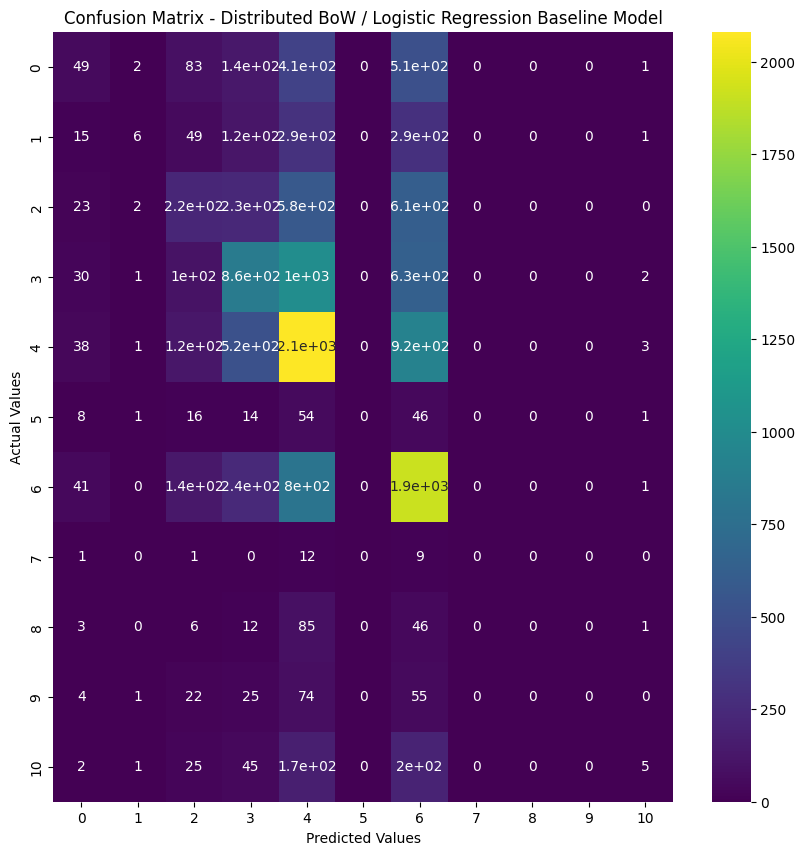

In [44]:
#Plotting the confusion matrix as heatmap
plt.figure(figsize=(10,10))
sns.heatmap(cm_lr_dbow, annot=True, cmap='viridis')
plt.title('Confusion Matrix - Distributed BoW / Logistic Regression Baseline Model')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [45]:
# Output targets and regressors from user-defined vec_for_learning function - dm model
y_train_dm, X_train_dm = vec_for_learning(model_dm, train_tagged)
y_val_dm, X_val_dm = vec_for_learning(model_dm, val_tagged)

In [46]:
# Baseline label classifier with Logistic Regression and minimal params - dm model

logreg_dm = LogisticRegression(
    max_iter=10000,
    random_state=2023,
)

logreg_dm.fit(X_train_dm, y_train_dm)

y_pred_dm = logreg_dm.predict(X_val_dm)
print('Validation accuracy %s' % accuracy_score(y_val_dm, y_pred_dm))
print('Validation f1 score %s' % f1_score(y_val_dm, y_pred_dm, average='weighted'))
cm_lr_dm = confusion_matrix(y_val_dm, y_pred_dm)
cr_lr_dm = pd.DataFrame(classification_report(y_val_dm, y_pred_dm, zero_division=1, output_dict=True)).T
cr_lr_dm

Validation accuracy 0.6968422553282486
Validation f1 score 0.6861588238489502


,precision,recall,f1-score,support
0,0.752000,0.548791,0.634523,1199.000000
1,0.759259,0.371762,0.499130,772.000000
2,0.651146,0.545946,0.593924,1665.000000
3,0.646771,0.753992,0.696278,2630.000000
4,0.628123,0.825285,0.713331,3686.000000
5,0.833333,0.321429,0.463918,140.000000
6,0.836210,0.819662,0.827853,3133.000000
7,1.000000,0.000000,0.000000,23.000000
8,0.470588,0.052288,0.094118,153.000000
9,0.716418,0.265193,0.387097,181.000000


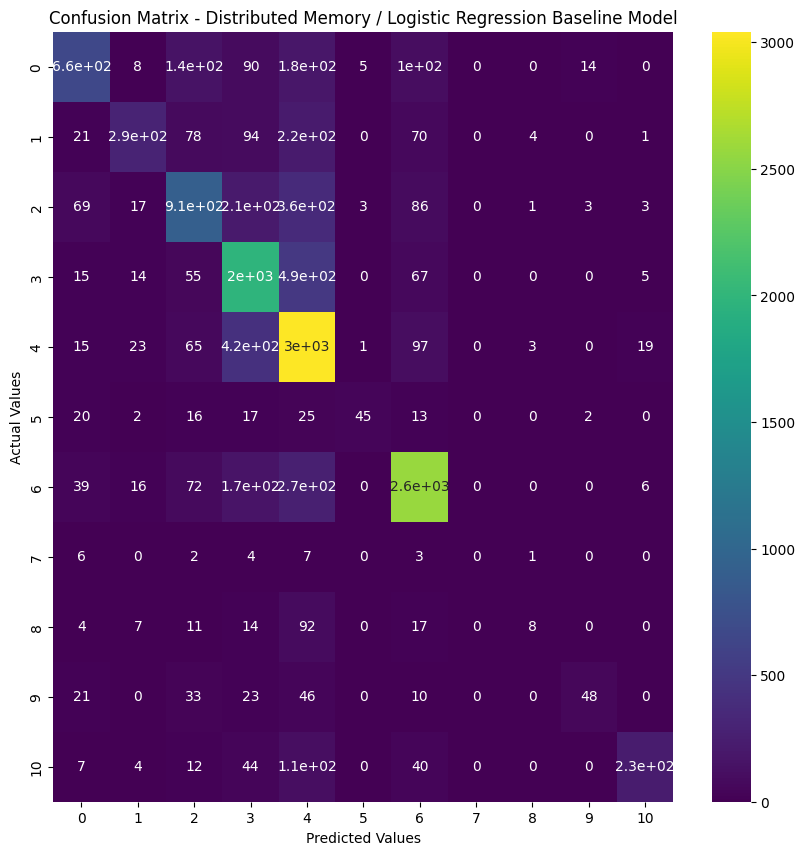

In [47]:
#Plotting the confusion matrix as heatmap
plt.figure(figsize=(10,10))
sns.heatmap(cm_lr_dm, annot=True, cmap='viridis')
plt.title('Confusion Matrix - Distributed Memory / Logistic Regression Baseline Model')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

- ### Distributed Memory (dm) model performs much better on baseline than Distributed Bag-of-Words (dbow) model.  Will utilize dm model for additional modeling
- ### Baseline logistic regression with dm performs moderately well with accuracy and f1 score ~70%, however, there is room for improvement.

In [48]:
# Rename dm targets and regressors to drop 'dm' suffix
y_train = y_train_dm
X_train = X_train_dm
y_val = y_val_dm 
X_val = X_val_dm

## Add engineered features to both training and validation data

In [49]:
# get engineered features together in place
numFeatures =['timely_response', 'consumer_disputed?', 'days_between_receipt_and_sent',
              'sub_product_freq', 'sub_product_null_flag', 'sub_product_low_flag', 'issue_freq',
              'issue_low_flag', 'sub_issue_freq','sub_issue_null_flag', 'sub_issue_low_flag',
              'company_public_response_freq', 'company_public_response_null_flag', 'company_public_response_low_flag',
              'company_freq', 'company_low_flag', 'state_freq', 'state_null_flag', 'state_low_flag',
              'zipcode_freq', 'zipcode_null_flag', 'zipcode_low_flag', 'Not Older American, Not Servicemember',
              'Older American', 'Older American, Servicemember', 'Servicemember', 'Closed', 'Closed with explanation',
              'Closed with monetary relief', 'Closed with non-monetary relief', 'Untimely response']

In [50]:
eng_features = StandardScaler().fit_transform(df_train[numFeatures])

In [52]:
X_train = np.column_stack((X_train, eng_features))

In [53]:
X_train_csr = csr_matrix(X_train).tocsr()

In [54]:
#Saving the combined features into an NPZ file
sparse.save_npz("./input/X_matrices/Doc2Vec/X_train.npz", X_train_csr)

In [55]:
X_train = X_train_csr

In [56]:
eng_features = StandardScaler().fit_transform(df_val[numFeatures])

In [57]:
X_val = np.column_stack((X_val, eng_features))

In [58]:
X_val_csr = csr_matrix(X_val).tocsr()

In [59]:
#Saving the combined features into an NPZ file
sparse.save_npz("./input/X_matrices/Doc2Vec/X_val.npz", X_val_csr)

In [60]:
X_val = X_val_csr

# Try hyperparameter optimization for the logistic regression model

In [68]:
# Optimize logistic regression classifier with optuna
def log_objective(trial):
    #penalty = trial.suggest_categorical("penalty", ["l2", "l1", "elasticnet", "none"]) #use defaut l2 penalty
    tol = trial.suggest_float("tol", 0.0001, 0.0091, step=0.001, log=False)
    C = trial.suggest_float("C", 0.1, 1.0, step=0.1, log=False)
    #fit_intercept = trial.suggest_categorical("fit_intercept", ["True", "False"])
    class_weight = trial.suggest_categorical("class_weight", ["balanced", None])
    solver = trial.suggest_categorical("solver", ["newton-cg", "lbfgs", "sag", "saga"]) #"liblinear", 
    #l1_ratio = trial.suggest_float("l1_ratio", 0.1, 1.0, step=0.1, log=False) ## only used by elasticnet
        
    ## Create Model
    log = LogisticRegression(tol=tol, C=C, class_weight=class_weight, solver=solver, 
                            max_iter=10000, multi_class = "multinomial", random_state = 2023)
    ## Fit Model
    log.fit(X_train, y_train)

    return accuracy_score(y_val, log.predict(X_val))

In [69]:
log_study = optuna.create_study(study_name="Logistic Regression Classifier", direction="maximize")
log_study.optimize(log_objective, n_trials=10)

[I 2023-01-08 15:13:43,932] A new study created in memory with name: Logistic Regression Classifier
[I 2023-01-08 15:16:32,461] Trial 0 finished with value: 0.9447572884738755 and parameters: {'tol': 0.0061, 'C': 0.5, 'class_weight': 'balanced', 'solver': 'newton-cg'}. Best is trial 0 with value: 0.9447572884738755.
[I 2023-01-08 15:19:49,162] Trial 1 finished with value: 0.9390548150260175 and parameters: {'tol': 0.0011, 'C': 0.4, 'class_weight': 'balanced', 'solver': 'saga'}. Best is trial 0 with value: 0.9447572884738755.
[I 2023-01-08 15:21:23,210] Trial 2 finished with value: 0.95502174068002 and parameters: {'tol': 0.0021, 'C': 1.0, 'class_weight': None, 'solver': 'sag'}. Best is trial 2 with value: 0.95502174068002.
[I 2023-01-08 15:23:18,016] Trial 3 finished with value: 0.9247273504882743 and parameters: {'tol': 0.0091, 'C': 0.1, 'class_weight': 'balanced', 'solver': 'lbfgs'}. Best is trial 2 with value: 0.95502174068002.
[I 2023-01-08 15:25:46,326] Trial 4 finished with value

In [70]:
print("Best Params: {}".format(log_study.best_params))
print("\nBest Accuracy: {}".format(log_study.best_value))

Best Params: {'tol': 0.0081, 'C': 0.8, 'class_weight': None, 'solver': 'lbfgs'}

Best Accuracy: 0.9580868201582436


In [71]:
log_clf = LogisticRegression(**log_study.best_params, max_iter=10000, multi_class = "multinomial", random_state = 2023)
log_clf.fit(X_train, y_train)

y_pred_train = log_clf.predict(X_train)
y_pred_val = log_clf.predict(X_val)

log_train_acc = accuracy_score(y_train, y_pred_train)
log_val_acc = accuracy_score(y_val, y_pred_val)

log_train_f1 = f1_score(y_train, y_pred_train, average='weighted')
log_val_f1 = f1_score(y_val, y_pred_val, average='weighted')

print("Logistic Regression Accuracy on Train Dataset: {}".format(log_train_acc))
print("\nLogistic Regression Accuracy on Validation Dataset: {}".format(log_val_acc))
print("#####################")
print("\nLogistic Regression F1 Score on Train Dataset: {}".format(log_train_f1))
print("\nLogistic Regression F1 Score on Validation Dataset: {}".format(log_val_f1))

# Create Validation Confusion Matrix and Classification Report
cm_log = confusion_matrix(y_val, y_pred_val)
cr_log = pd.DataFrame(classification_report(y_val, y_pred_val, zero_division=1, output_dict=True)).T
cr_log

Logistic Regression Accuracy on Train Dataset: 0.9740826276623044

Logistic Regression Accuracy on Validation Dataset: 0.9580868201582436
#####################

Logistic Regression F1 Score on Train Dataset: 0.9740182920668915

Logistic Regression F1 Score on Validation Dataset: 0.9577012546252486


,precision,recall,f1-score,support
0,0.858421,0.879900,0.869028,1199.000000
1,0.837696,0.829016,0.833333,772.000000
2,1.000000,1.000000,1.000000,1665.000000
3,1.000000,1.000000,1.000000,2630.000000
4,0.984178,0.995659,0.989885,3686.000000
5,0.673611,0.692857,0.683099,140.000000
6,0.969520,0.954357,0.961879,3133.000000
7,0.200000,0.043478,0.071429,23.000000
8,0.950000,0.993464,0.971246,153.000000
9,0.725225,0.889503,0.799007,181.000000


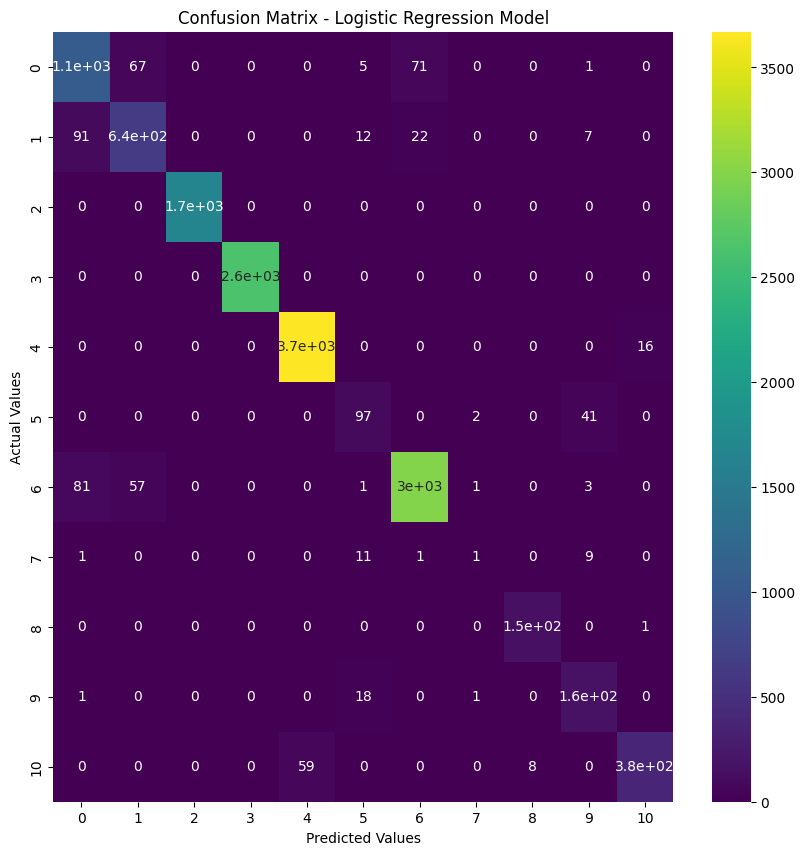

In [72]:
# Plotting the confusion matrix as heatmap
plt.figure(figsize=(10,10))
sns.heatmap(cm_log, annot=True, cmap='viridis')
plt.title('Confusion Matrix - Logistic Regression Model')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

- ### The addition of engineered features to the document vector resulted in great improvement for the Logistic Regression Classifier in terms of validation accuracy and f1 score.
- ### Classification heatmap demonstrates very good classification overall but high degree of misclassifications for class 4.
- ### Classifier had some confusion issues predicting Class 0 for Class 1 (bidirectionally) and Class 6, Class 1 for Class 6, Class 4 for Class 10, and Class 9 for Class 5.
- ### Class 7 with least amount of support (23 samples) was only correctly predicted once.  Class 7 was only predicted 3 other times and incorrectly.
- ### Overfitting with this model is not much of a concern since metrics on training and validation data are similar.

# Try other classification model types with hyperparameter optimization

## Passive Aggressive Classifier

In [76]:
# Passive Aggressive Classifier needs scaling preprocessing for input training data
scaler = MaxAbsScaler() #StandardScaler() #MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
# Scale X_val data the same as X_train data
X_val_scaled = scaler.fit_transform(X_val)

# Optimize passive aggressive classifier with optuna
def pac_objective(trial):
    C = trial.suggest_float("C", 0.1, 1.0, step=0.1, log=False)
    tol = trial.suggest_float("tol", 0.001, 0.01, step=0.001, log=False)
    loss = trial.suggest_categorical("loss", ["hinge", "squared_hinge"])
    class_weight = trial.suggest_categorical("class_weight", ["balanced", None])
            
    ## Create Model
    pac = PassiveAggressiveClassifier(C=C, tol=tol, loss=loss, class_weight=class_weight, 
                                        max_iter=10000, random_state = 2023) 

    ## Fit Model
    pac.fit(X_train_scaled, y_train)

    return accuracy_score(y_val, pac.predict(X_val_scaled))

In [77]:
pac_study = optuna.create_study(study_name="Passive Aggressive Classifier", direction="maximize")
pac_study.optimize(pac_objective, n_trials=10)

[I 2023-01-08 17:16:01,361] A new study created in memory with name: Passive Aggressive Classifier
[I 2023-01-08 17:16:07,780] Trial 0 finished with value: 0.9002067146624848 and parameters: {'C': 0.9, 'tol': 0.002, 'loss': 'hinge', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.9002067146624848.
[I 2023-01-08 17:16:11,260] Trial 1 finished with value: 0.9488203008054744 and parameters: {'C': 0.6, 'tol': 0.007, 'loss': 'hinge', 'class_weight': None}. Best is trial 1 with value: 0.9488203008054744.
[I 2023-01-08 17:16:15,497] Trial 2 finished with value: 0.8692707962078552 and parameters: {'C': 0.8, 'tol': 0.007, 'loss': 'squared_hinge', 'class_weight': 'balanced'}. Best is trial 1 with value: 0.9488203008054744.
[I 2023-01-08 17:16:20,363] Trial 3 finished with value: 0.9429039846033217 and parameters: {'C': 0.4, 'tol': 0.002, 'loss': 'hinge', 'class_weight': None}. Best is trial 1 with value: 0.9488203008054744.
[I 2023-01-08 17:16:24,245] Trial 4 finished with value: 0.90

In [78]:
print("Best Params: {}".format(pac_study.best_params))
print("\nBest Accuracy: {}".format(pac_study.best_value))

Best Params: {'C': 0.6, 'tol': 0.007, 'loss': 'hinge', 'class_weight': None}

Best Accuracy: 0.9488203008054744


In [79]:
pac_clf = PassiveAggressiveClassifier(**pac_study.best_params, max_iter=10000, random_state = 2023)
pac_clf.fit(X_train_scaled, y_train)

y_pred_train = pac_clf.predict(X_train_scaled)
y_pred_val = pac_clf.predict(X_val_scaled)

pac_train_acc = accuracy_score(y_train, y_pred_train)
pac_val_acc = accuracy_score(y_val, y_pred_val)

pac_train_f1 = f1_score(y_train, y_pred_train, average='weighted')
pac_val_f1 = f1_score(y_val, y_pred_val, average='weighted')

print("Passive Aggressive Classifier Accuracy on Train Dataset: {}".format(pac_train_acc))
print("\nPassive Aggressive Classifier Accuracy on Validation Dataset: {}".format(pac_val_acc))
print("#####################")
print("\nPassive Aggressive Classifier F1 Score on Train Dataset: {}".format(pac_train_f1))
print("\nPassive Aggressive Classifier F1 Score on Validation Dataset: {}".format(pac_val_f1))

# Create Validation Confusion Matrix and Classification Report
cm_pac = confusion_matrix(y_val, y_pred_val)
cr_pac = pd.DataFrame(classification_report(y_val, y_pred_val, zero_division=1, output_dict=True)).T
cr_pac

Passive Aggressive Classifier Accuracy on Train Dataset: 0.9640107775211701

Passive Aggressive Classifier Accuracy on Validation Dataset: 0.9488203008054744
#####################

Passive Aggressive Classifier F1 Score on Train Dataset: 0.9634792266979321

Passive Aggressive Classifier F1 Score on Validation Dataset: 0.9480467886258511


,precision,recall,f1-score,support
0,0.833333,0.829858,0.831592,1199.00000
1,0.754171,0.878238,0.811490,772.00000
2,0.998194,0.995796,0.996993,1665.00000
3,1.000000,0.999240,0.999620,2630.00000
4,0.978075,0.992404,0.985187,3686.00000
5,0.870130,0.478571,0.617512,140.00000
6,0.968535,0.943185,0.955692,3133.00000
7,0.000000,0.000000,0.000000,23.00000
8,0.949686,0.986928,0.967949,153.00000
9,0.683983,0.872928,0.766990,181.00000


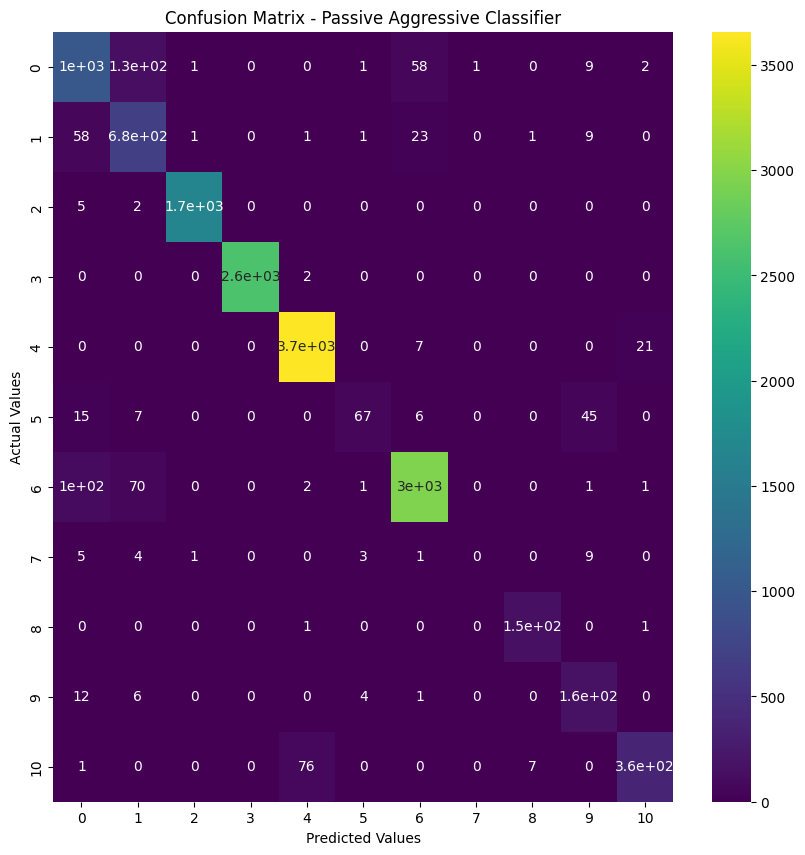

In [80]:
# Plotting the confusion matrix as heatmap
plt.figure(figsize=(10,10))
sns.heatmap(cm_pac, annot=True, cmap='viridis')
plt.title('Confusion Matrix - Passive Aggressive Classifier')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

- ### Passive Aggressive Classifier performed only slightly worse than Logistic Regression Classifier in terms of accuracy and f1 score.
- ### Classification heatmap demonstrates fairly good classification overall but high degree of misclassifications in Class 6 misclassified as Class 0 and Class 0 misclassified as Class 1.
- ### Classifier also had some confusion issues predicting Class 0 for Class 1, Class 1 for Class 6, Class 4 for Class 10, Class 6 for Classes 0 and 1, and Class 9 for Class 5.  These were all similar misclassifications as the Logistic Regression Classifier.
- ### Class 7 with least amount of support (23 samples) was only predicted once and incorrectly.
- ### Slight evidence of overfitting with marginally higher metrics on training data.

## Random Forest Classifier

In [81]:
# Optimize Random Forest Classifier with optuna
def rfc_objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 550, step=100, log=False)
    criterion = trial.suggest_categorical("criterion", ["gini", "entropy", "log_loss"])
    max_depth = trial.suggest_int("max_depth", 2, 10, step=2, log=False)
    min_samples_split = trial.suggest_int("min_samples_split", 20, 100, step=20, log=False)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 10, 50, step=10, log=False)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])
    class_weight = trial.suggest_categorical("class_weight", ["balanced", "balanced_subsample"])
            
    ## Create Model
    rfc = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split, 
                                    min_samples_leaf=min_samples_leaf, max_features=max_features, bootstrap=bootstrap, class_weight=class_weight, 
                                    random_state = 2023) 

    ## Fit Model
    rfc.fit(X_train, y_train)

    return accuracy_score(y_val, rfc.predict(X_val))

In [82]:
rfc_study = optuna.create_study(study_name="Random Forest Classifier", direction="maximize")
rfc_study.optimize(rfc_objective, n_trials=10)

[I 2023-01-08 17:16:52,839] A new study created in memory with name: Random Forest Classifier
[I 2023-01-08 17:23:43,111] Trial 0 finished with value: 0.8526623422909687 and parameters: {'n_estimators': 450, 'criterion': 'log_loss', 'max_depth': 8, 'min_samples_split': 40, 'min_samples_leaf': 50, 'max_features': 'log2', 'bootstrap': True, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.8526623422909687.
[I 2023-01-08 17:40:56,979] Trial 1 finished with value: 0.9194525625490056 and parameters: {'n_estimators': 550, 'criterion': 'log_loss', 'max_depth': 8, 'min_samples_split': 60, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': True, 'class_weight': 'balanced_subsample'}. Best is trial 1 with value: 0.9194525625490056.
[I 2023-01-08 17:54:59,094] Trial 2 finished with value: 0.9215197091738542 and parameters: {'n_estimators': 450, 'criterion': 'entropy', 'max_depth': 8, 'min_samples_split': 40, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': True, 'c

In [83]:
print("Best Params: {}".format(rfc_study.best_params))
print("\nBest Accuracy: {}".format(rfc_study.best_value))

Best Params: {'n_estimators': 350, 'criterion': 'entropy', 'max_depth': 8, 'min_samples_split': 60, 'min_samples_leaf': 20, 'max_features': None, 'bootstrap': False, 'class_weight': 'balanced'}

Best Accuracy: 0.9679235868557987


In [84]:
rfc_clf = RandomForestClassifier(**rfc_study.best_params, random_state = 2023)
rfc_clf.fit(X_train, y_train)

y_pred_train = rfc_clf.predict(X_train)
y_pred_val = rfc_clf.predict(X_val)

rfc_train_acc = accuracy_score(y_train, y_pred_train)
rfc_val_acc = accuracy_score(y_val, y_pred_val)

rfc_train_f1 = f1_score(y_train, y_pred_train, average='weighted')
rfc_val_f1 = f1_score(y_val, y_pred_val, average='weighted')

print("Random Forest Classifier Accuracy on Train Dataset: {}".format(rfc_train_acc))
print("\nRandom Forest Classifier Accuracy on Validation Dataset: {}".format(rfc_val_acc))
print("#####################")
print("\nRandom Forest Classifier F1 Score on Train Dataset: {}".format(rfc_train_f1))
print("\nRandom Forest Classifier F1 Score on Validation Dataset: {}".format(rfc_val_f1))

# Create Validation Confusion Matrix and Classification Report
cm_rfc = confusion_matrix(y_val, y_pred_val)
cr_rfc = pd.DataFrame(classification_report(y_val, y_pred_val, zero_division=1, output_dict=True)).T
cr_rfc

Random Forest Classifier Accuracy on Train Dataset: 0.9809041142759387

Random Forest Classifier Accuracy on Validation Dataset: 0.9679235868557987
#####################

Random Forest Classifier F1 Score on Train Dataset: 0.981325821307944

Random Forest Classifier F1 Score on Validation Dataset: 0.9675295063721595


,precision,recall,f1-score,support
0,0.937959,0.958299,0.948020,1199.000000
1,0.775720,0.976684,0.864679,772.000000
2,1.000000,1.000000,1.000000,1665.000000
3,1.000000,1.000000,1.000000,2630.000000
4,1.000000,1.000000,1.000000,3686.000000
5,0.388430,0.335714,0.360153,140.000000
6,1.000000,0.944462,0.971438,3133.000000
7,0.396552,1.000000,0.567901,23.000000
8,1.000000,1.000000,1.000000,153.000000
9,0.584071,0.364641,0.448980,181.000000


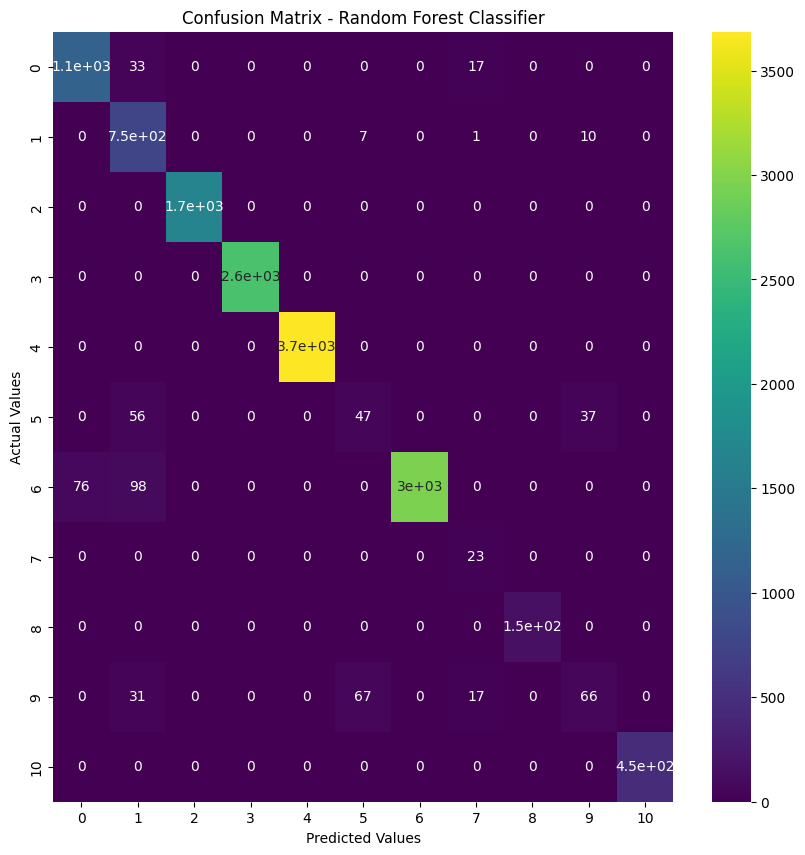

In [85]:
# Plotting the confusion matrix as heatmap
plt.figure(figsize=(10,10))
sns.heatmap(cm_rfc, annot=True, cmap='viridis')
plt.title('Confusion Matrix - Random Forest Classifier')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

- ### Random Forest Classifier performed slightly better than both the Logistic Regression Classifier and Passive Aggressive Classifier in terms of validation accuracy and f1 score.
- ### Classification heatmap demonstrates very good classification overall.
- ### Classifier had some confusion issues predicting Class 0 for Class 6; Class 1 for Classes 6, 5, 0, and 9; Class 5 for Class 9 (both bidirectionally).
- ### Class 7 with least amount of support (23 samples) was correctly predicted all 23 times for a perfect recall score.  However, it was also incorrectly predicted 35 times.
- ### Slight evidence of overfitting with marginally higher metrics on training data.

## XGBoost Classifier

In [86]:
# XGBoost Classifier needs y_train label encoded
#le = LabelEncoder() #scaler = StandardScaler()
#y_train_le = le.fit_transform(y_train)

# Optimize XGBoost Classifier Classifier with optuna
def xgb_objective(trial):
    booster = trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"])
    eta = trial.suggest_float("eta", 0.1, 1.0, step=0.1, log=False)
    gamma = trial.suggest_int("gamma", 0, 100, step=10, log=False)
    max_depth = trial.suggest_int("max_depth", 2, 42, step=4, log=False)
    min_child_weight = trial.suggest_int("min_child_weight", 0, 50, step=10, log=False)
    subsample = trial.suggest_float("subsample", 0.5, 1.0, step=0.1, log=False)
    #sampling_method = trial.suggest_categorical("sampling_method", ["uniform", "gradient_based"]) #gradient_based only for tree_method: gpu_hist
            
    ## Create Model
    xgb = XGBClassifier(booster=booster, eta=eta, gamma=gamma, max_depth=max_depth, min_child_weight=min_child_weight, 
                            subsample=subsample, eval_metric="mlogloss", random_state = 2023) #, use_label_encoder=False

    ## Fit Model
    xgb.fit(X_train, y_train)

    return accuracy_score(y_val, xgb.predict(X_val))

In [87]:
xgb_study = optuna.create_study(study_name="XGBoost Classifier", direction="maximize")
xgb_study.optimize(xgb_objective, n_trials=10)

[I 2023-01-09 02:44:29,209] A new study created in memory with name: XGBoost Classifier


[02:44:29] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "gamma", "max_depth", "min_child_weight", "subsample" } are not used.



[I 2023-01-09 02:44:48,253] Trial 0 finished with value: 0.0854658207997719 and parameters: {'booster': 'gblinear', 'eta': 0.8, 'gamma': 50, 'max_depth': 26, 'min_child_weight': 40, 'subsample': 1.0}. Best is trial 0 with value: 0.0854658207997719.
[I 2023-01-09 02:46:51,586] Trial 1 finished with value: 0.9567324827143774 and parameters: {'booster': 'gbtree', 'eta': 0.4, 'gamma': 50, 'max_depth': 42, 'min_child_weight': 50, 'subsample': 0.6}. Best is trial 1 with value: 0.9567324827143774.
[I 2023-01-09 02:57:56,853] Trial 2 finished with value: 0.9501746382493407 and parameters: {'booster': 'dart', 'eta': 0.5, 'gamma': 50, 'max_depth': 14, 'min_child_weight': 20, 'subsample': 0.5}. Best is trial 1 with value: 0.9567324827143774.
[I 2023-01-09 03:08:30,994] Trial 3 finished with value: 0.9143916173640316 and parameters: {'booster': 'dart', 'eta': 0.4, 'gamma': 100, 'max_depth': 2, 'min_child_weight': 0, 'subsample': 0.8}. Best is trial 1 with value: 0.9567324827143774.
[I 2023-01-09 0

In [88]:
print("Best Params: {}".format(xgb_study.best_params))
print("\nBest Accuracy: {}".format(xgb_study.best_value))

Best Params: {'booster': 'gbtree', 'eta': 0.30000000000000004, 'gamma': 0, 'max_depth': 42, 'min_child_weight': 10, 'subsample': 0.7}

Best Accuracy: 0.9568750445505738


In [89]:
xgb_clf = XGBClassifier(**xgb_study.best_params, eval_metric="mlogloss", random_state = 2023) #, use_label_encoder=False
xgb_clf.fit(X_train, y_train)

y_pred_train = xgb_clf.predict(X_train)
y_pred_val = xgb_clf.predict(X_val)

xgb_train_acc = accuracy_score(y_train, y_pred_train)
xgb_val_acc = accuracy_score(y_val, y_pred_val)

xgb_train_f1 = f1_score(y_train, y_pred_train, average='weighted')
xgb_val_f1 = f1_score(y_val, y_pred_val, average='weighted')

print("XGBoost Classifier Accuracy on Train Dataset: {}".format(xgb_train_acc))
print("\nXGBoost Classifier Accuracy on Validation Dataset: {}".format(xgb_val_acc))
print("#####################")
print("\nXGBoost Classifier F1 Score on Train Dataset: {}".format(xgb_train_f1))
print("\nXGBoost Classifier F1 Score on Validation Dataset: {}".format(xgb_val_f1))

# Create Validation Confusion Matrix and Classification Report
cm_xgb = confusion_matrix(y_val, y_pred_val)
cr_xgb = pd.DataFrame(classification_report(y_val, y_pred_val, zero_division=1, output_dict=True)).T
cr_xgb

XGBoost Classifier Accuracy on Train Dataset: 1.0

XGBoost Classifier Accuracy on Validation Dataset: 0.9568750445505738
#####################

XGBoost Classifier F1 Score on Train Dataset: 1.0

XGBoost Classifier F1 Score on Validation Dataset: 0.9544030547637056


,precision,recall,f1-score,support
0,0.878428,0.988324,0.930141,1199.000000
1,0.943333,0.733161,0.825073,772.000000
2,1.000000,1.000000,1.000000,1665.000000
3,1.000000,1.000000,1.000000,2630.000000
4,0.991321,0.991590,0.991455,3686.000000
5,0.528090,0.335714,0.410480,140.000000
6,0.940308,0.975423,0.957543,3133.000000
7,0.301370,0.956522,0.458333,23.000000
8,1.000000,0.529412,0.692308,153.000000
9,0.564516,0.386740,0.459016,181.000000


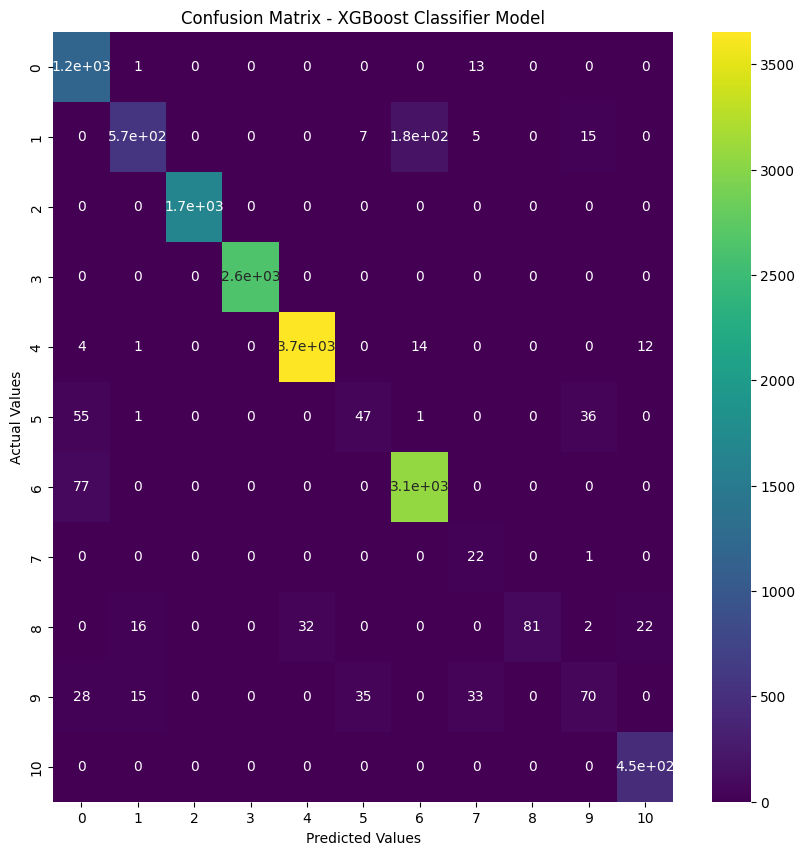

In [90]:
#Plotting the confusion matrix as heatmap
plt.figure(figsize=(10,10))
sns.heatmap(cm_xgb, annot=True, cmap='viridis')
plt.title('Confusion Matrix - XGBoost Classifier Model')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

- ### XGBoost Classifier performed similar to the Logistic Regression Classifier in terms of validation accuracy and f1 score.
- ### Classification heatmap demonstrates good classification overall but high degree of misclassifications predicting Class 6 for Class 1.
- ### Classifier also had some confusion issues predicting Class 0 for Classes 6, 5, and 9; Class 4 for Class 8; Class 5 for Class 9 (both bidirectionally).
- ### Class 7 with least amount of support (23 samples) was correctly predicted 22 times for a near perfect recall score.  However, it was also incorrectly predicted 51 times.
- ### Extreme evidence of overfitting with perfect metrics on training data.

## LightGBM Classifier

In [91]:
# Optimize LightGBM Classifier Classifier with optuna
def lgb_objective(trial):
    #boosting_type = trial.suggest_categorical("boosting_type", ["gbdt", "dart", "goss", "rf"])
    num_leaves = trial.suggest_int("num_leaves", 4, 20, step=4, log=False)
    max_depth = trial.suggest_int("max_depth", 2, 8, step=2, log=False)
    learning_rate = trial.suggest_float("learning_rate", 0.001, 0.010, step=0.001, log=False)
    n_estimators = trial.suggest_int("n_estimators", 350, 500, step=25, log=False)
    min_child_weight = trial.suggest_float("min_child_weight", 0.01, 0.10, step=0.01, log=False)
    min_child_samples = trial.suggest_int("min_child_samples", 100, 200, step=25, log=False)
    subsample = trial.suggest_float("subsample", 0.2, 1.0, step=0.2, log=False)
            
    ## Create Model
    lgb = LGBMClassifier(boosting_type="gbdt", num_leaves=num_leaves, max_depth=max_depth, learning_rate=learning_rate, 
                            n_estimators=n_estimators, min_child_weight=min_child_weight, min_child_samples=min_child_samples, 
                            subsample=subsample, objective="multiclass", random_state = 2023) 

    ## Fit Model
    lgb.fit(X_train, y_train)

    return accuracy_score(y_val, lgb.predict(X_val))

In [92]:
lgb_study = optuna.create_study(study_name="LightGBM Classifier", direction="maximize")
lgb_study.optimize(lgb_objective, n_trials=10)

[I 2023-01-09 03:33:28,592] A new study created in memory with name: LightGBM Classifier
[I 2023-01-09 03:33:57,667] Trial 0 finished with value: 0.9037707605673961 and parameters: {'num_leaves': 16, 'max_depth': 2, 'learning_rate': 0.003, 'n_estimators': 475, 'min_child_weight': 0.03, 'min_child_samples': 100, 'subsample': 1.0}. Best is trial 0 with value: 0.9037707605673961.
[I 2023-01-09 03:34:47,695] Trial 1 finished with value: 0.8776106636253475 and parameters: {'num_leaves': 16, 'max_depth': 8, 'learning_rate': 0.008, 'n_estimators': 350, 'min_child_weight': 0.09999999999999999, 'min_child_samples': 200, 'subsample': 0.6000000000000001}. Best is trial 0 with value: 0.9037707605673961.
[I 2023-01-09 03:35:46,414] Trial 2 finished with value: 0.8927222182621712 and parameters: {'num_leaves': 20, 'max_depth': 6, 'learning_rate': 0.01, 'n_estimators': 375, 'min_child_weight': 0.01, 'min_child_samples': 125, 'subsample': 1.0}. Best is trial 0 with value: 0.9037707605673961.
[I 2023-0

In [93]:
print("Best Params: {}".format(lgb_study.best_params))
print("\nBest Accuracy: {}".format(lgb_study.best_value))

Best Params: {'num_leaves': 16, 'max_depth': 2, 'learning_rate': 0.005, 'n_estimators': 450, 'min_child_weight': 0.09999999999999999, 'min_child_samples': 175, 'subsample': 0.4}

Best Accuracy: 0.9189535961223181


In [94]:
lgb_clf = LGBMClassifier(**lgb_study.best_params, boosting_type="gbdt", objective="multiclass", random_state = 2023)
lgb_clf.fit(X_train, y_train)

y_pred_train = lgb_clf.predict(X_train)
y_pred_val = lgb_clf.predict(X_val)

lgb_train_acc = accuracy_score(y_train, y_pred_train)
lgb_val_acc = accuracy_score(y_val, y_pred_val)

lgb_train_f1 = f1_score(y_train, y_pred_train, average='weighted')
lgb_val_f1 = f1_score(y_val, y_pred_val, average='weighted')

print("LightGBM Classifier Accuracy on Train Dataset: {}".format(lgb_train_acc))
print("\nLightGBM Classifier Accuracy on Validation Dataset: {}".format(lgb_val_acc))
print("#####################")
print("\nLightGBM Classifier F1 Score on Train Dataset: {}".format(lgb_train_f1))
print("\nLightGBM Classifier F1 Score on Validation Dataset: {}".format(lgb_val_f1))

# Create Validation Confusion Matrix and Classification Report
cm_lgb = confusion_matrix(y_val, y_pred_val)
cr_lgb = pd.DataFrame(classification_report(y_val, y_pred_val, zero_division=1, output_dict=True)).T
cr_lgb

LightGBM Classifier Accuracy on Train Dataset: 0.9953169104439312

LightGBM Classifier Accuracy on Validation Dataset: 0.9189535961223181
#####################

LightGBM Classifier F1 Score on Train Dataset: 0.9953680346033128

LightGBM Classifier F1 Score on Validation Dataset: 0.913282152777684


,precision,recall,f1-score,support
0,0.820743,0.534612,0.647475,1199.000000
1,0.876841,0.848446,0.862409,772.000000
2,1.000000,1.000000,1.000000,1665.000000
3,0.999620,1.000000,0.999810,2630.000000
4,0.983634,0.962018,0.972706,3686.000000
5,0.979167,0.335714,0.500000,140.000000
6,0.824164,0.975423,0.893437,3133.000000
7,0.607143,0.739130,0.666667,23.000000
8,1.000000,0.398693,0.570093,153.000000
9,0.671958,0.701657,0.686486,181.000000


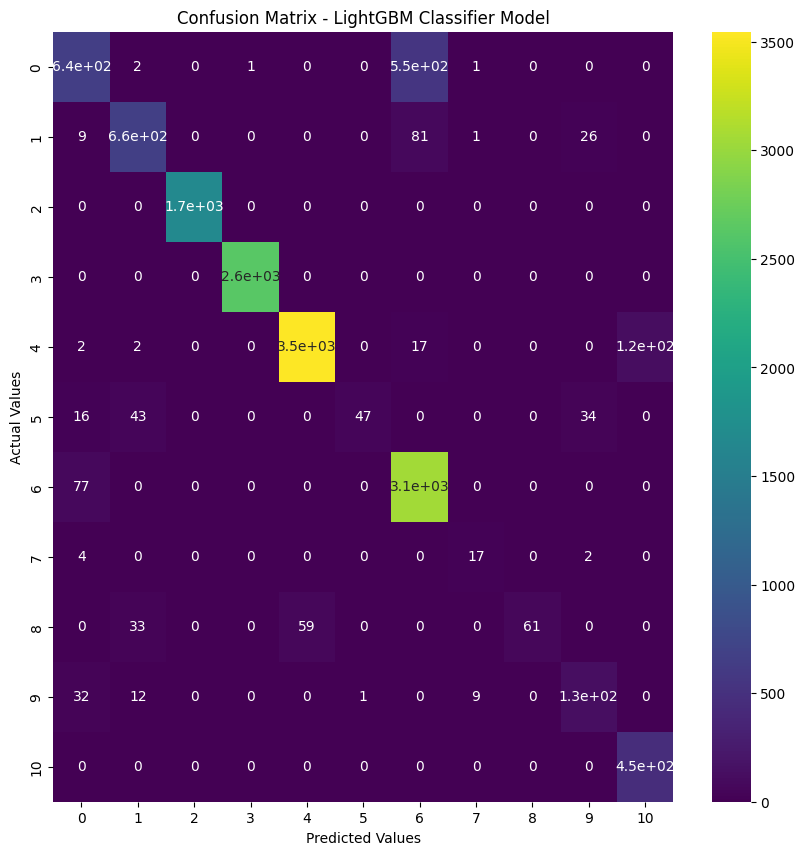

In [95]:
#Plotting the confusion matrix as heatmap
plt.figure(figsize=(10,10))
sns.heatmap(cm_lgb, annot=True, cmap='viridis')
plt.title('Confusion Matrix - LightGBM Classifier Model')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

- ### LightGBM Classifier performed worse than the other classifiers in terms of validation accuracy and f1 score.
- ### Classification heatmap demonstrates fairly good classification overall but with a high degree of misclassifications predicting Class 6 for Class 0 and Class 10 for Class 4.
- ### Classifier also had some confusion issues predicting Class 0 for Classes 6 and 9; Class 1 for Classes 8 and 9; Class 4 for Class 8; Class 6 for Class 1; and Class 9 for Classes 5 and 1.
- ### Class 7 with least amount of support (23 samples) was correctly predicted 17 times and was also incorrectly predicted 11 times.
- ### Extreme evidence of overfitting with much higher metrics on training data.

## Save models

In [96]:
# save models
pickle.dump(log_clf, open('./bin/Doc2Vec/log_clf_trained.pkl', 'wb'))
pickle.dump(pac_clf, open('./bin/Doc2Vec/pac_clf_trained.pkl', 'wb'))
pickle.dump(rfc_clf, open('./bin/Doc2Vec/rfc_clf_trained.pkl', 'wb'))
pickle.dump(xgb_clf, open('./bin/Doc2Vec/xgb_clf_trained.pkl', 'wb'))
pickle.dump(lgb_clf, open('./bin/Doc2Vec/lgb_clf_trained.pkl', 'wb'))

## Ensemble best models together to balance bias-variance tradeoff / mitigate any overfitting.

In [97]:
# load 3 best saved models with high metrics on validation data and low evidence of overfitting to training data.
log_clf = pickle.load(open('./bin/Doc2Vec/log_clf_trained.pkl', 'rb'))
pac_clf = pickle.load(open('./bin/Doc2Vec/pac_clf_trained.pkl', 'rb'))
rfc_clf = pickle.load(open('./bin/Doc2Vec/rfc_clf_trained.pkl', 'rb'))

In [98]:
ensemble_clf = VotingClassifier(estimators=[('log', log_clf), ('pac', pac_clf), ('rfc', rfc_clf)], 
                                    voting='hard') # can't use 'soft' argmax voting since pac only has predict and not predict_proba

In [99]:
ensemble_clf = ensemble_clf.fit(X_train, y_train)

In [127]:
y_pred_train_ensemble = ensemble_clf.predict(X_train)
y_pred_val_ensemble = ensemble_clf.predict(X_val)

In [128]:
results_ensemble_train_acc = accuracy_score(y_train, y_pred_train_ensemble)
results_ensemble_val_acc = accuracy_score(y_val, y_pred_val_ensemble)

results_ensemble_train_f1 = f1_score(y_train, y_pred_train_ensemble, average='weighted')
results_ensemble_val_f1 = f1_score(y_val, y_pred_val_ensemble, average='weighted')

print("Ensemble Accuracy on Train Dataset: {}".format(results_ensemble_train_acc))
print("\nEnsemble Accuracy on Validation Dataset: {}".format(results_ensemble_val_acc))
print("#####################")
print("\nEnsemble F1 Score on Train Dataset: {}".format(results_ensemble_train_f1))
print("\nEnsemble F1 Score on Validation Dataset: {}".format(results_ensemble_val_f1))

# Create Validation Confusion Matrix and Classification Report
cm_ensemble_val = confusion_matrix(y_val, y_pred_val_ensemble)
cr_ensemble_val = pd.DataFrame(classification_report(y_val, y_pred_val_ensemble, zero_division=1, output_dict=True)).T
cr_ensemble_val

Ensemble Accuracy on Train Dataset: 0.9806688905996065

Ensemble Accuracy on Validation Dataset: 0.9674246204291111
#####################

Ensemble F1 Score on Train Dataset: 0.9806157569313446

Ensemble F1 Score on Validation Dataset: 0.9670465161007827


,precision,recall,f1-score,support
0,0.873832,0.935780,0.903745,1199.000000
1,0.878396,0.879534,0.878964,772.000000
2,0.998800,1.000000,0.999400,1665.000000
3,1.000000,1.000000,1.000000,2630.000000
4,0.984759,0.999186,0.991920,3686.000000
5,0.729927,0.714286,0.722022,140.000000
6,0.982617,0.956272,0.969266,3133.000000
7,0.285714,0.086957,0.133333,23.000000
8,0.962264,1.000000,0.980769,153.000000
9,0.803030,0.878453,0.839050,181.000000


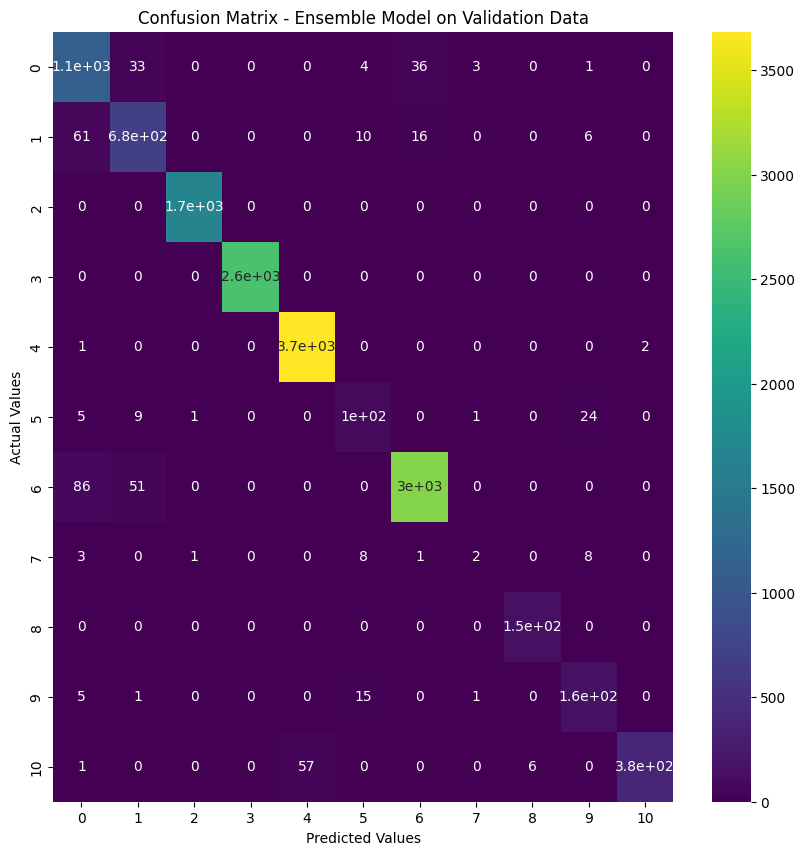

In [129]:
#Plotting the confusion matrix as heatmap
plt.figure(figsize=(10,10))
sns.heatmap(cm_ensemble_val, annot=True, cmap='viridis')
plt.title('Confusion Matrix - Ensemble Model on Validation Data')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

- ### Ensemble Model performed about the same as the best single model (Random Forest Classifier) in terms of validation accuracy and f1 score.
- ### Classification heatmap demonstrates very good classification overall.
- ### Classifier had some confusion issues predicting Class 0 for Classes 6 and 1 (all bidirectionally); Class 4 for Class 10; and Class 9 for Class 5.
- ### Class 7 with least amount of support (23 samples) was only correctly predicted twice and was incorrectly predicted 5 times.
- ### Very slight evidence of overfitting (slightly less than Random Forest Classifier) with marginally higher metrics on training data.

## Save ensemble model

In [102]:
pickle.dump(ensemble_clf, open('./bin/Doc2Vec/ensemble_clf_trained.pkl', 'wb'))

## Load and compare the Ensemble Classifier performance on the test data

In [103]:
df_test = pd.read_parquet('./input/dataframes/df_test_FE.parquet')
df_test.head()

,consumer_complaint_narrative,timely_response,consumer_disputed?,days_between_receipt_and_sent,sub_product_freq,sub_product_null_flag,sub_product_low_flag,issue_freq,issue_low_flag,sub_issue_freq,sub_issue_null_flag,sub_issue_low_flag,company_public_response_freq,company_public_response_null_flag,company_public_response_low_flag,company_freq,company_low_flag,state_freq,state_null_flag,state_low_flag,zipcode_freq,zipcode_null_flag,zipcode_low_flag,"Not Older American, Not Servicemember",Older American,"Older American, Servicemember",Servicemember,Closed,Closed with explanation,Closed with monetary relief,Closed with non-monetary relief,Untimely response
0,My husband and I agreed to pay off our mortgag...,1,0,0,0.008482,0,1,0.098287,0,-1.000000,1,0,0.293032,0,0,0.043406,0,0.037086,0,0,0.001330,0,0,0,1,0,0,0,1,0,0,0
1,I am filing a complaint because EQUIFAX has ig...,1,0,0,-1.000000,1,0,0.028771,0,0.012806,0,0,-1.000000,1,0,0.061034,0,0.020289,0,0,0.005322,0,0,1,0,0,0,0,1,0,0,0
2,This account is fraudulent and the company ref...,1,1,0,0.059538,0,0,0.110095,0,0.010311,0,0,-1.000000,1,0,0.000333,1,0.013637,0,0,0.001829,0,0,1,0,0,0,0,1,0,0,0
3,"Again, I lived in XXXX from : XX/XX/XXXX, unti...",1,0,3,0.056710,0,0,0.012972,0,-1.000000,1,0,0.293032,0,0,0.004823,1,0.002994,0,1,0.000499,0,1,0,0,1,0,0,1,0,0,0
4,This company calls multiple times a day despit...,1,0,0,0.059538,0,0,0.043240,0,0.023283,0,0,-1.000000,1,0,0.009147,1,0.032762,0,0,0.002661,0,0,1,0,0,0,0,0,0,1,0


In [104]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6013 entries, 0 to 6012
Data columns (total 32 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   consumer_complaint_narrative           6013 non-null   object 
 1   timely_response                        6013 non-null   int32  
 2   consumer_disputed?                     6013 non-null   int32  
 3   days_between_receipt_and_sent          6013 non-null   int64  
 4   sub_product_freq                       6013 non-null   float64
 5   sub_product_null_flag                  6013 non-null   int32  
 6   sub_product_low_flag                   6013 non-null   int32  
 7   issue_freq                             6013 non-null   float64
 8   issue_low_flag                         6013 non-null   int32  
 9   sub_issue_freq                         6013 non-null   float64
 10  sub_issue_null_flag                    6013 non-null   int32  
 11  sub_

In [105]:
df_test.shape

(6013, 32)

In [106]:
list(df_test.columns)

['consumer_complaint_narrative',
 'timely_response',
 'consumer_disputed?',
 'days_between_receipt_and_sent',
 'sub_product_freq',
 'sub_product_null_flag',
 'sub_product_low_flag',
 'issue_freq',
 'issue_low_flag',
 'sub_issue_freq',
 'sub_issue_null_flag',
 'sub_issue_low_flag',
 'company_public_response_freq',
 'company_public_response_null_flag',
 'company_public_response_low_flag',
 'company_freq',
 'company_low_flag',
 'state_freq',
 'state_null_flag',
 'state_low_flag',
 'zipcode_freq',
 'zipcode_null_flag',
 'zipcode_low_flag',
 'Not Older American, Not Servicemember',
 'Older American',
 'Older American, Servicemember',
 'Servicemember',
 'Closed',
 'Closed with explanation',
 'Closed with monetary relief',
 'Closed with non-monetary relief',
 'Untimely response']

## Import label-encoded targets for test data

In [107]:
# Test data targets
y_test = pd.read_parquet('./input/y_targets/y_test_LE.parquet')

In [108]:
product_test = y_test['label'].value_counts()
print(product_test)

4     1580
6     1343
3     1128
2      714
0      514
1      331
10     191
9       77
8       65
5       60
7       10
Name: label, dtype: int64


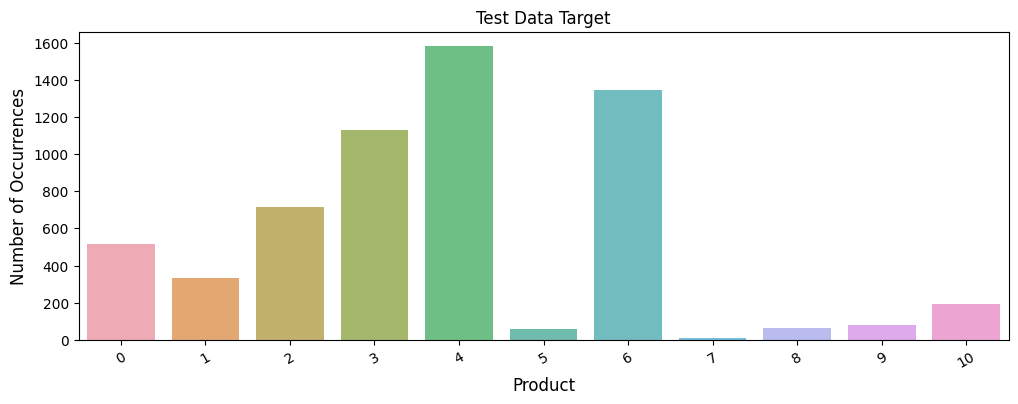

In [109]:
plt.figure(figsize=(12,4))
sns.barplot(x=product_test.index, y=product_test.values, alpha=0.8)
plt.title('Test Data Target')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.xticks(rotation=30)
plt.show()

## Inspect unvectorized text and ensure all is converted to string for both Test Data

In [110]:
for i in df_test['consumer_complaint_narrative'].head(5):
    print(i)
    print("#####################")

My husband and I agreed to pay off our mortgage. We felt the best way to pay this off would be to start making a payment per day. Our payment amount is less than {$600.00}. We decided to pay {$600.00} each day until the mortgage was completely payed off. Understanding that we confirmed with the bank that each payment would be recognized as a monthly payment. And we would not be held responsible for payments in arrears, should either of us fall ill and not be able to make a payment during a 90 day period that would let us rest at ease that payments represented a monthly payment. We see a full months amount of interest taken out of the payment, even though we have made the payments on a daily basis. or even several payments on one day. A mortgage should be interest calculated on the days required between payments against the balance. May we please have this in writing as to why they are making this payment as principal and interest for the full month 's interest? Am I mistaken on this is

In [111]:
df_test = df_test.rename({'consumer_complaint_narrative':'unvec'},axis=1)

In [112]:
df_test['unvec'] = df_test['unvec'].astype(str)

## Join text and targets for tagging

In [113]:
df_test = df_test.join(y_test)

## Sanitize text

In [114]:
df_test = clean_text_df(df_test)

In [115]:
for i in df_test['unvec'].head(5):
    print(i)
    print("#####################")

husband agreed pay mortgage felt best way pay would start making payment per day payment amount le decided pay day mortgage completely payed understanding confirmed bank payment would recognized monthly payment would held responsible payment arrears either u fall ill able make payment day period would let u rest ease payment represented monthly payment see full month amount interest taken payment even though made payment daily basis even several payment one day mortgage interest calculated day required payment balance may please writing making payment principal interest full month 's interest mistaken issue tell would problem escrow case could pay separately interest need corrected thought thank time consideration matter included documentation show application payment balance mortgage mortgage department helpful situation seems longer use regular method calculating interest given away automation calculated computer longer application master trifle ordinary statement sent soon make paym

## Tag Documents

In [116]:
test_tagged = df_test.apply(
    lambda x: TaggedDocument(words=tokenize_text(x['unvec']), tags=[x['label']]), axis=1)

In [117]:
test_tagged.values[0]

TaggedDocument(words=['husband', 'agreed', 'pay', 'mortgage', 'felt', 'best', 'way', 'pay', 'would', 'start', 'making', 'payment', 'per', 'day', 'payment', 'amount', 'le', 'decided', 'pay', 'day', 'mortgage', 'completely', 'payed', 'understanding', 'confirmed', 'bank', 'payment', 'would', 'recognized', 'monthly', 'payment', 'would', 'held', 'responsible', 'payment', 'arrears', 'either', 'fall', 'ill', 'able', 'make', 'payment', 'day', 'period', 'would', 'let', 'rest', 'ease', 'payment', 'represented', 'monthly', 'payment', 'see', 'full', 'month', 'amount', 'interest', 'taken', 'payment', 'even', 'though', 'made', 'payment', 'daily', 'basis', 'even', 'several', 'payment', 'one', 'day', 'mortgage', 'interest', 'calculated', 'day', 'required', 'payment', 'balance', 'may', 'please', 'writing', 'making', 'payment', 'principal', 'interest', 'full', 'month', "'s", 'interest', 'mistaken', 'issue', 'tell', 'would', 'problem', 'escrow', 'case', 'could', 'pay', 'separately', 'interest', 'need', '

In [118]:
# Output targets and regressors from user-defined vec_for_learning function - dm model
y_test, X_test = vec_for_learning(model_dm, test_tagged)

## Add engineered features to test data

In [120]:
eng_features = StandardScaler().fit_transform(df_test[numFeatures])

In [121]:
X_test = np.column_stack((X_test, eng_features))

In [122]:
X_test_csr = csr_matrix(X_test).tocsr()

In [123]:
#Saving the combined features into an NPZ file
sparse.save_npz("./input/X_matrices/Doc2Vec/X_test.npz", X_test_csr)

In [124]:
X_test = X_test_csr

## Use ensemble model to predict on out-of-sample test dataset

In [130]:
y_pred_train_ensemble = ensemble_clf.predict(X_train)
y_pred_test_ensemble = ensemble_clf.predict(X_test)

In [131]:
results_ensemble_train_acc = accuracy_score(y_train, y_pred_train_ensemble)
results_ensemble_test_acc = accuracy_score(y_test, y_pred_test_ensemble)

results_ensemble_train_f1 = f1_score(y_train, y_pred_train_ensemble, average='weighted')
results_ensemble_test_f1 = f1_score(y_test, y_pred_test_ensemble, average='weighted')

print("Ensemble Accuracy on Train Dataset: {}".format(results_ensemble_train_acc))
print("\nEnsemble Accuracy on Test Dataset: {}".format(results_ensemble_test_acc))
print("#####################")
print("\nEnsemble F1 Score on Train Dataset: {}".format(results_ensemble_train_f1))
print("\nEnsemble F1 Score on Test Dataset: {}".format(results_ensemble_test_f1))

# Create Test Confusion Matrix and Classification Report
cm_ensemble_test = confusion_matrix(y_test, y_pred_test_ensemble)
cr_ensemble_test = pd.DataFrame(classification_report(y_test, y_pred_test_ensemble, zero_division=1, output_dict=True)).T
cr_ensemble_test

Ensemble Accuracy on Train Dataset: 0.9806688905996065

Ensemble Accuracy on Test Dataset: 0.9539331448528189
#####################

Ensemble F1 Score on Train Dataset: 0.9806157569313446

Ensemble F1 Score on Test Dataset: 0.952253119271881


,precision,recall,f1-score,support
0,0.833046,0.941634,0.884018,514.000000
1,0.853731,0.864048,0.858859,331.000000
2,1.000000,1.000000,1.000000,714.000000
3,1.000000,1.000000,1.000000,1128.000000
4,0.961047,0.999367,0.979832,1580.000000
5,0.531915,0.416667,0.467290,60.000000
6,0.986739,0.941921,0.963810,1343.000000
7,0.000000,0.000000,0.000000,10.000000
8,0.955882,1.000000,0.977444,65.000000
9,0.741573,0.857143,0.795181,77.000000


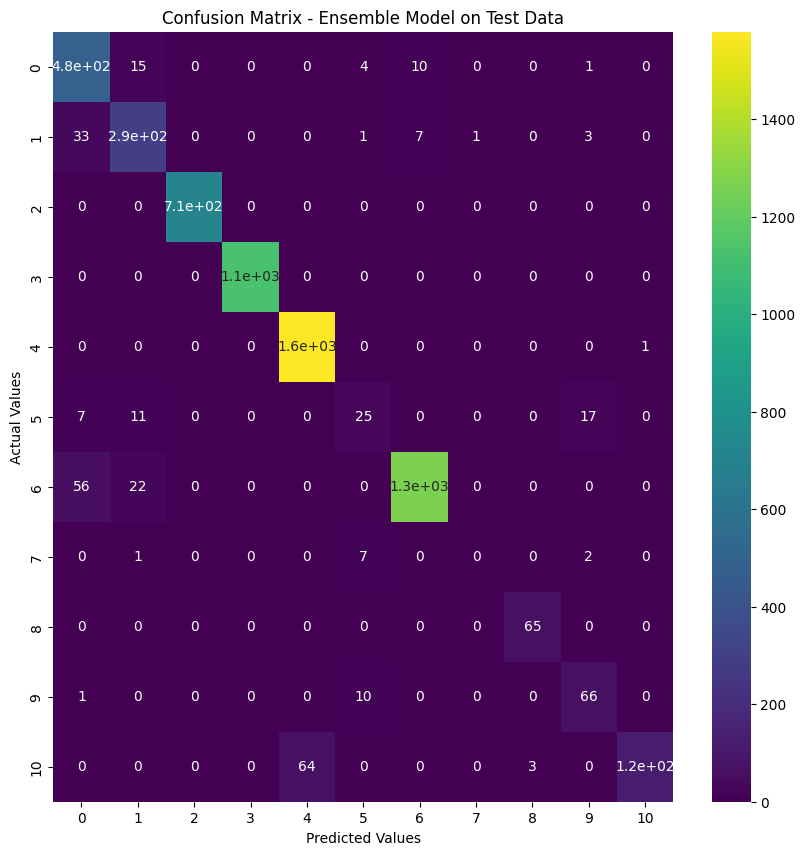

In [132]:
#Plotting the confusion matrix as heatmap
plt.figure(figsize=(10,10))
sns.heatmap(cm_ensemble_test, annot=True, cmap='viridis')
plt.title('Confusion Matrix - Ensemble Model on Test Data')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

- ### Ensemble Model performed only slightly worse on the test data accuracy and f1 score when compared to the validation dataset.
- ### Classification heatmap demonstrates very good classification overall.
- ### Classifier had some confusion issues predicting Class 0 for Classes 6 and 1; and 4 for Class 10.
- ### Class 7 with least amount of support (10 samples) was not correctly predicted once but was incorrectly predicted once.
- ### Slightly higher evidence of overfitting with marginally higher metrics on training data when compared to test data.

## Use Random Forest Classifier (best single model) to predict on out-of-sample test dataset

In [133]:
y_pred_train_rfc = rfc_clf.predict(X_train)
y_pred_test_rfc = rfc_clf.predict(X_test)

In [134]:
results_rfc_train_acc = accuracy_score(y_train, y_pred_train_rfc)
results_rfc_test_acc = accuracy_score(y_test, y_pred_test_rfc)

results_rfc_train_f1 = f1_score(y_train, y_pred_train_rfc, average='weighted')
results_rfc_test_f1 = f1_score(y_test, y_pred_test_rfc, average='weighted')

print("Random Forest (Single Model) Accuracy on Train Dataset: {}".format(results_rfc_train_acc))
print("\nRandom Forest (Single Model) Accuracy on Test Dataset: {}".format(results_rfc_test_acc))
print("#####################")
print("\nRandom Forest (Single Model) F1 Score on Train Dataset: {}".format(results_rfc_train_f1))
print("\nRandom Forest (Single Model) F1 Score on Test Dataset: {}".format(results_rfc_test_f1))

# Create Test Confusion Matrix and Classification Report
cm_rfc_test = confusion_matrix(y_test, y_pred_test_rfc)
cr_rfc_test = pd.DataFrame(classification_report(y_test, y_pred_test_rfc, zero_division=1, output_dict=True)).T
cr_rfc_test

Random Forest (Single Model) Accuracy on Train Dataset: 0.9809041142759387

Random Forest (Single Model) Accuracy on Test Dataset: 0.9447862963578912
#####################

Random Forest (Single Model) F1 Score on Train Dataset: 0.981325821307944

Random Forest (Single Model) F1 Score on Test Dataset: 0.9396810761490628


,precision,recall,f1-score,support
0,0.923933,0.968872,0.945869,514.000000
1,0.787286,0.972810,0.870270,331.000000
2,1.000000,1.000000,1.000000,714.000000
3,1.000000,1.000000,1.000000,1128.000000
4,0.930769,0.995570,0.962080,1580.000000
5,0.000000,0.000000,0.000000,60.000000
6,1.000000,0.940432,0.969302,1343.000000
7,0.500000,1.000000,0.666667,10.000000
8,1.000000,1.000000,1.000000,65.000000
9,0.515152,0.441558,0.475524,77.000000


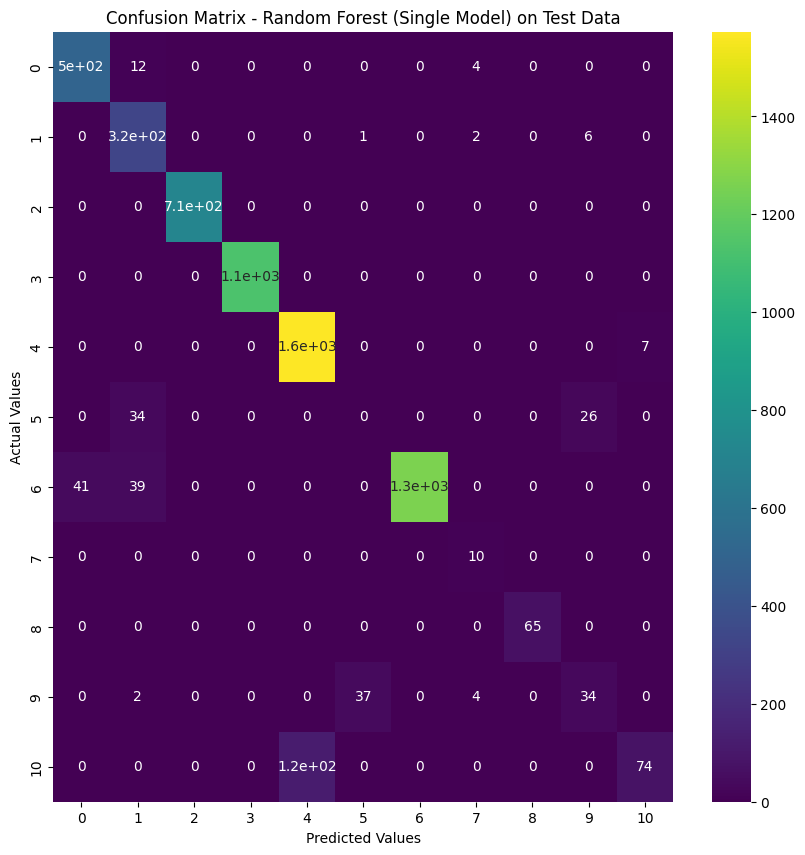

In [135]:
#Plotting the confusion matrix as heatmap
plt.figure(figsize=(10,10))
sns.heatmap(cm_rfc_test, annot=True, cmap='viridis')
plt.title('Confusion Matrix - Random Forest (Single Model) on Test Data')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

- ### Random Forest Classifier (Single Model) performed slightly worse on the test data accuracy and f1 score when compared to the Ensemble Model.
- ### Classification heatmap demonstrates very good classification overall but with a high degree of misclassifications predicting Class 4 for Class 10.
- ### Classifier also had some confusion issues predicting Class 0 for Class 6; Class 1 for Classes 6 and 5; Class 5 for Class 9 (bidirectionally).
- ### Class 7 with least amount of support (10 samples) was correctly predicted all 10 times but Class 7 was also incorrectly predicted 10 times.
- ### Slightly higher evidence of overfitting with slightly higher metrics on training data when compared to test data and also when compared to Ensemble performance on the test data.

## Final Thoughts:
- ### Test dataset accuracy and f1 score for the Ensemble Classifier was very similar to the Random Forest Classifier's performance on the validation dataset but better than the Random Forest Classifier's performance on the test dataset.  
- ### The Random Forest Classifier was better at predicting Class 7 (the class with least support) in both the validation and test datasets than the Ensemble Classifier.
- ### The Ensemble Classifier seems to be a better candidate for Model Selection than the Random Forest Classifier in terms of less overfitting to the training data.  However, further refinement would be helpful to improve the Ensemble Classifier's ability to predict Class 7.
- ### Evaluation of transformers follows in notebook # 03.